# Imports

In [1]:
import sys
sys.path.append('../src')

from feature_manager import spatial_bin, color_hist, hog_hist

import os
import matplotlib.pyplot as plt
import numpy as np

import pickle
from tqdm import tqdm

from skimage import io

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

data_path = '../data'

# Vehicles / Non vehicles dataset

In [2]:
vehicles_data_path = os.path.join(data_path, 'vehicles')
non_vehicles_data_path = os.path.join(data_path, 'non-vehicles')

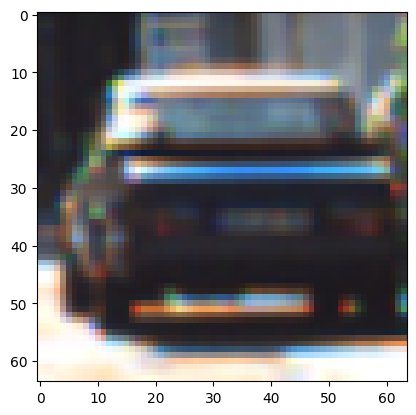

In [3]:
frame = io.imread(os.path.join(vehicles_data_path, '1.png'))

plt.imshow(frame)
plt.show()

# Parameters

In [4]:
channel_axis = 2

orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
transform_sqrt = True

color_bins_n = 32
color_bins_range = (0, 256)

spatial_size = (32, 32)

# Feature extraction

In [5]:
def feature_extraction(
    image, 
    spatial_size,
    color_bins_n, color_bins_range,
    orientations, pixels_per_cell, cells_per_block, transform_sqrt,
    channel_axis=None
):
    
    features = []

    spatial_features = spatial_bin(
        image, 
        size=spatial_size
    )
    features.append(spatial_features)

    color_features = color_hist(
        image, 
        nbins=color_bins_n, bins_range=color_bins_range
    )
    features.append(color_features)

    if channel_axis is not None:
        for channel in range(image.shape[channel_axis]):
            hog_features = hog_hist(
                image[:,:,channel],
                orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                transform_sqrt=transform_sqrt
            )
            features.append(hog_features)
    else:
        hog_features = hog_hist(
                image,
                orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                transform_sqrt=transform_sqrt
            )
        features.append(hog_features)

    return np.concatenate(features)

In [6]:
features = feature_extraction(
    frame,
    spatial_size=(32, 32),
    color_bins_n=32, color_bins_range=(0, 256),
    orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), transform_sqrt=True,
    channel_axis=2
)

features.shape

(8460,)

# Data loading

In [7]:
def load_vehicle_data(data_path, folder_name):
    
    image_paths = []
    labels = []

    path = os.path.join(data_path, folder_name)

    for file in os.listdir(path):
        image_paths.append(os.path.join(path, file))
        labels.append(folder_name)

    return np.array(image_paths), np.array(labels)

Images shape: (8374,)
Labels shape: (8374,)
Vehicle sample: ../data\vehicles\1.png
Images shape: (8968,)
Labels shape: (8968,)
Non vehicle sample: ../data\non-vehicles\extra1.png


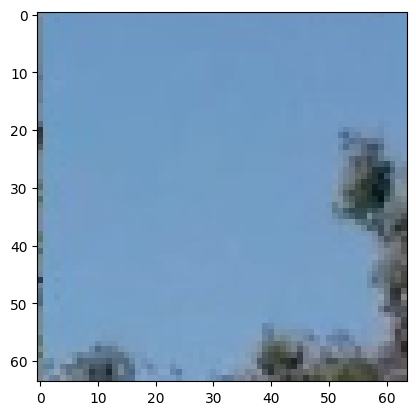

In [8]:
image_paths, labels = load_vehicle_data(data_path, 'vehicles')

print(f"Images shape: {image_paths.shape}")
print(f"Labels shape: {labels.shape}")

print(f"Vehicle sample: {image_paths[0]}")

image_paths, labels = load_vehicle_data(data_path, 'non-vehicles')

print(f"Images shape: {image_paths.shape}")
print(f"Labels shape: {labels.shape}")

print(f"Non vehicle sample: {image_paths[0]}")

plt.imshow(io.imread(image_paths[0]))
plt.show()

# Feature pipeline

In [8]:
def feature_pipeline(
    image_paths, 
    spatial_size,
    color_bins_n, color_bins_range,
    orientations, pixels_per_cell, cells_per_block, transform_sqrt,
    channel_axis=None
):

    features = []
    
    for image_path in tqdm(image_paths):
        frame = io.imread(image_path)
        frame_features = feature_extraction(
            frame,
            spatial_size=spatial_size,
            color_bins_n=color_bins_n, color_bins_range=color_bins_range,
            orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
            transform_sqrt=transform_sqrt, channel_axis=channel_axis
        )
        features.append(frame_features)
        
    features = np.array(features)

    return features

# Preprocessing

In [9]:
def preprocessing(
    data_path, folders,
    spatial_size,
    color_bins_n, color_bins_range,
    orientations, pixels_per_cell, cells_per_block, transform_sqrt,
    channel_axis=None,
    verbose=False
):
    
    image_paths = []
    labels = []

    for folder in folders:
        folder_image_paths, folder_labels = load_vehicle_data(data_path, folder)
        image_paths.extend(folder_image_paths)
        labels.extend(folder_labels)
    
    image_paths = np.array(image_paths)
    labels = np.array(labels)

    if verbose:
        print(f"Image paths shape: {image_paths.shape}")
        print(f"Labels shapes: {labels.shape}")

    X = feature_pipeline(
        image_paths, 
        spatial_size,
        color_bins_n, color_bins_range,
        orientations, pixels_per_cell, cells_per_block, transform_sqrt,
        channel_axis=channel_axis
    )
                   
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)

    y = np.array([1 if label=='vehicles' else 0 for label in labels])
    
    return X_scaled, X_scaler, y 

In [12]:
X_scaled, X_scaler, y = preprocessing(
    data_path, ['vehicles', 'non-vehicles'],
    spatial_size,
    color_bins_n, color_bins_range,
    orientations, pixels_per_cell, cells_per_block, transform_sqrt,
    channel_axis,
    verbose=True
)

print(X_scaled.shape)
print(X_scaler)
print(y.shape)
print(y[:5])
print(y[-1])

Image paths shape: (17342,)
Labels shapes: (17342,)


100%|██████████| 17342/17342 [02:01<00:00, 142.85it/s]


(17342, 8460)
StandardScaler()
(17342,)
[1 1 1 1 1]
0


In [14]:
with open('models/classification_dataset_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file)

# Classification

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, random_state=42
)

svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy of SVC =  0.9864


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Gridsearch

In [51]:
linear_svc_model = LinearSVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
}

grid_search = GridSearchCV(estimator=linear_svc_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-pa

Best Parameters:  {'C': 1}
Best Accuracy: 98.65%


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [54]:
grid_search.best_params_

{'C': 1}

In [62]:
final_linear_svc = LinearSVC(**grid_search.best_params_)
print(final_linear_svc)

final_linear_svc.fit(X_train, y_train)
print('Test Accuracy of retained LinearSVC = ', round(final_linear_svc.score(X_test, y_test), 4))

with open('models/final_linear_svm_model_weights.pkl', 'wb') as file:
    pickle.dump(final_linear_svc, file)

LinearSVC(C=1)


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy of retained LinearSVC =  0.9864


In [63]:
with open('models/final_linear_svm_model_weights.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

loaded_model.fit(X_train, y_train)
print('Test Accuracy of retained LinearSVC = ', round(loaded_model.score(X_test, y_test), 4))

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy of retained LinearSVC =  0.9864
